# Torsional rotordynamics with Python

Copyright: Sampo Laine and Samuli Rytömaa 2023


In [60]:
%%capture
%pip install opentorsion

import numpy as np
import opentorsion as ot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

np.set_printoptions(precision=2)

print("Libraries loaded")

In [61]:
# This cell will be removed before tutorial (moved to openTorsion when next release is made)


def ss_response(excitations, omegas, M, C, K):
    # Next line is only for getting the shape of the response
    q_matrix = np.zeros((M.shape[0], len(omegas)), dtype="complex128")
    w_matrix = np.zeros((M.shape[0], len(omegas)), dtype="complex128")

    for i, w in enumerate(omegas):
        receptance = np.linalg.inv(-M * w**2 + w * 1.0j * C + K)
        q = receptance @ np.array([excitations[:, i]]).T
        w = receptance @ (1.0j * w * excitations[:, i])
        q_matrix[:, i] = q.ravel()
        w_matrix[:, i] = w.ravel()

    return q_matrix, w_matrix


def plot_eigenmodes(assembly, modes=5):
    """
    Updated eigenmode plot. Geared systems not supported.
    The eigenvectors are plotted over the assembly schematic, and the trajectories are plotted with dashed lines.
    Each plotted eigenvector is rotated so that the node with maximum abs displacement has phase of 0

    Parameters
    ----------
    modes : int
        Number of eigenodes to be plotted
    """
    eigenmodes = assembly.eigenmodes()
    phases = np.angle(eigenmodes)
    nodes = np.arange(0, assembly.dofs)

    fig_modes, axs = plt.subplots(modes, 1, sharex=True)

    for i in range(modes):
        eigenvector = eigenmodes[:, i]
        max_disp = np.argmax(np.abs(eigenvector))
        eigenvector_rotated = eigenvector * np.exp(-1.0j * phases[max_disp, i])

        plot_on_ax(assembly, axs[i], alpha=0.2)
        axs[i].plot(
            nodes, np.real(eigenvector_rotated) / np.sqrt(np.sum(np.real(eigenvector_rotated) ** 2)), color="red"
        )
        axs[i].plot([nodes, nodes], [np.abs(eigenvector_rotated), -np.abs(eigenvector_rotated)], "--", color="black")
        axs[i].set_ylim([-1.1, 1.1])
    plt.show()


def plot_campbell(
    assembly, frequency_range_rpm=[0, 1000], num_modes=5, harmonics=[1, 2, 3, 4], operating_speeds_rpm=[]
):
    """
    Plots the Campbell diagram

    Parameters
    ----------
    frequency_range : list, optional
        Analysis frequency range, default is 0 to 100 Hz
    num_modes : int, optional
        Number of modes to be plotted
    harmonics : list, optional
            List containing the harmonic multipliers, default is 1 through 4
    """
    fig, ax = plt.subplots()

    # Operating speeds
    for i, operating_speed_rpm in enumerate(operating_speeds_rpm):
        ax.plot(
            [operating_speed_rpm, operating_speed_rpm],
            [0, harmonics[-1] * (frequency_range_rpm[1] + 50) / 60],
            "--",
            color="red",
        )
        rectangle = patches.Rectangle(
            (operating_speed_rpm * 0.9, 0),
            operating_speed_rpm * 0.2,
            harmonics[-1] * (frequency_range_rpm[1] + 50) / 60,
            color="blue",
            alpha=0.2,
        )
        ax.add_patch(rectangle)

    harmonics = sorted(harmonics)

    undamped_nf, damped_nf, damping_ratios = modal_analysis(assembly)
    freqs = undamped_nf[::2] / (2 * np.pi)
    freqs = freqs[:num_modes]

    # Natural frequencies
    for i, freq in enumerate(freqs):
        ax.plot(frequency_range_rpm, [freq, freq], color="black", label=f"$f_{i}$={freq.round(2)} Hz")
        ax.text(1.01 * frequency_range_rpm[1], freq, f"$f_{i}$")

    # Diagonal lines
    for i, harmonic in enumerate(harmonics):
        ax.plot(frequency_range_rpm, [0, harmonic * (frequency_range_rpm[1] + 50) / 60], color="blue")
        ax.text(0.90 * frequency_range_rpm[1], 0.95 * (frequency_range_rpm[1] + 50) * harmonic / 60, f"{harmonic}x")
    ax.legend(loc="upper left")
    ax.set_xlim(frequency_range_rpm)
    ax.set_xlabel("Excitation frequency (rpm)")
    ax.set_ylabel("Natural Frequency (Hz)")
    plt.show()

    return


def plot_on_ax(assembly, ax, alpha=1):
    """
    Plots disk and spring elements

    Parameters:
    -----------
    assembly : openTorsion Assembly class instance

    ax : matplotlib Axes class instance
        The Axes where the elements are plotted
    alpha : float, optional
        Adjust the opacity of the plotted elements
    """
    disks = assembly.disk_elements
    shafts = assembly.shaft_elements
    max_I_disk = max(disks, key=lambda disk: disk.I)
    min_I_disk = min(disks, key=lambda disk: disk.I)
    max_I_value = max_I_disk.I
    min_I_value = min_I_disk.I
    disk_max, disk_min = 2, 0.5
    width = 0.5
    num_segments = 6  # number of lines in a spring
    amplitude = 0.1  # spring "height"

    for i, shaft in enumerate(shafts):  # plot springs connecting the disk elements
        if i < len(shafts):
            x1, y1 = shaft.nl + width / 2, 0
            x2, y2 = shaft.nr - width / 2, 0
            x_values = np.linspace(x1, x2, num_segments)
            y_values = np.linspace(y1, y2, num_segments)
            for i in range(0, num_segments):
                if i % 2 == 0:
                    y_values[i] += amplitude
                else:
                    y_values[i] -= amplitude
            for i in range(num_segments - 1):
                ax.plot(x_values[i : i + 2], y_values[i : i + 2], color="k", alpha=alpha)

    for i, disk in enumerate(disks):  # plot disk elements
        node = disk.node
        height = (disk.I - min_I_value) / (max_I_value - min_I_value) * (disk_max - disk_min) + disk_min
        pos = (node - width / 2, -height / 2)
        ax.add_patch(
            patches.Rectangle(
                pos, width, height, fill=True, edgecolor="black", facecolor="darkgrey", linewidth=1.5, alpha=alpha
            )
        )
    return


def modal_analysis(assembly):
    M, C, K = assembly.M(), assembly.C(), assembly.K()
    A = np.vstack(
        [np.hstack([np.zeros(M.shape), np.eye(M.shape[0])]), np.hstack([-np.linalg.inv(M) @ K, -np.linalg.inv(M) @ C])]
    )

    evals, evecs = np.linalg.eig(A)
    wn = np.abs(evals)
    wd = np.imag(evals)
    damping_ratios = -np.real(evals) / np.abs(evals)

    return wn[::-1], wd[::-1], damping_ratios[::-1]


def draw_zigzag(ax, start, end, num_segments=6, amplitude=0.1):
    x1, y1 = start
    x2, y2 = end

    x_values = np.linspace(x1, x2, num_segments)
    y_values = np.linspace(y1, y2, num_segments)

    for i in range(0, num_segments):
        if i % 2 == 0:
            y_values[i] += amplitude
        else:
            y_values[i] -= amplitude

    for i in range(num_segments - 1):
        ax.plot(x_values[i : i + 2], y_values[i : i + 2], color="k")


def plot_assembly(assembly):
    disks = assembly.disk_elements
    shafts = assembly.shaft_elements

    max_I_disk = max(disks, key=lambda disk: disk.I)
    min_I_disk = min(disks, key=lambda disk: disk.I)
    max_I_value = max_I_disk.I
    min_I_value = min_I_disk.I

    disk_max = 2
    disk_min = 0.5

    fig, ax = plt.subplots(figsize=(5, 4))

    width = 0.5
    for i, shaft in enumerate(shafts):
        if i < len(shafts):
            draw_zigzag(ax, (shaft.nl + width / 2, 0), (shaft.nr - width / 2, 0), 6, 0.1)

    for i, disk in enumerate(disks):
        node = disk.node
        height = (disk.I - min_I_value) / (max_I_value - min_I_value) * (disk_max - disk_min) + disk_min
        pos = (node - width / 2, -height / 2)

        ax.add_patch(
            patches.Rectangle(pos, width, height, fill=True, edgecolor="black", facecolor="darkgrey", linewidth=1.5)
        )

    plt.ylim((-2 * disk_max, 2 * disk_max))

    ax.set_xticks(np.arange(0, len(disks), step=1))
    ax.set_xlabel("node")
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()


## 1. Lumped element model


To demonstrate the use of openTorsion, we will create a model of a simple powertrain. The powertrain consists of a compressor, a turbine and a generator, and couplings between the components. A schematic of the powertrain is illustrated below. The design rotational speed of the system is 3600 rpm. We want to calculate the torsional natural frequencies and mode shapes of the powertrain, to estimate its critical speeds. The natural frequencies of torsional vibrations are calculated using standard theory of linear dynamics.


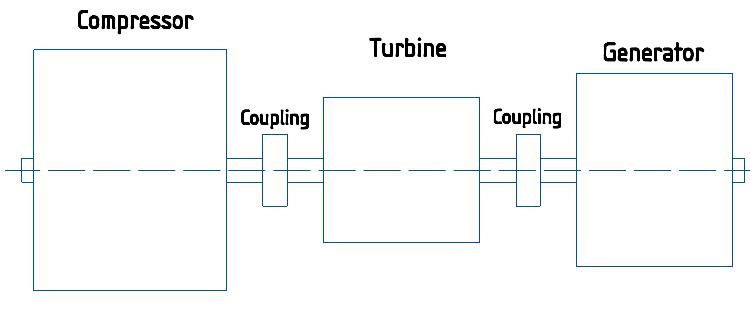


The modeling process starts by defining the lumped element model. The model consists of 5 lumped inertia elements, and 4 connecting shafts.

The rotational inertia of the compressor, turbine and generator are 100, 50 and 80 kgm$^2$, respectively. The couplings have rotational inertia of 10 kgm$^2$. The stiffness of all the shafts connecting the components to each other is 25 MNm/rad.

To model the powertrain, 5 disk elements are connected to each other using a total of 4 shaft elements. When creating the model, one must be careful when defining the node numbers, to ensure that the correct elements are correctly connected. The model is illustrated below by openTorsion.


### 1.1. Create necessary elements


In [62]:
"""
The shaft elements are created below.
To create a shaft element, call the ot.Shaft() method. As parameters, it takes
the numbers of the two nodes it is connecting and the shaft's rotational
stifness (k). Alternatively to the stiffness, the dimensions of the shaft element can be
given length (L) & outer diameter (odl), and openTorsion will calculate the element's stiffness.
The method returns the created shaft element.
"""

# Below, we create the 4 shaft elements in the model
shaft1 = ot.Shaft(0, 1, L=None, odl=None, k=25e6)
shaft2 = ot.Shaft(1, 2, L=None, odl=None, k=25e6)
shaft3 = ot.Shaft(2, 3, L=None, odl=None, k=25e6)
shaft4 = ot.Shaft(3, 4, L=None, odl=None, k=25e6)

"""
To create a disk element, call the ot.Disk() method. As parameters, it takes
the node number where the disk is placed, and the disk's rotational inertia (I).
The method returns the created disk element.
"""

# Below, we create the 5 disk elements in the model
disk1 = ot.Disk(0, I=100)  # Compressor
disk2 = ot.Disk(1, I=10)  # Coupling #1
disk3 = ot.Disk(2, I=50)  # Turbine
disk4 = ot.Disk(3, I=10)  # Coupling #2
disk5 = ot.Disk(4, I=80)  # Generator


### 1.2. Combine elements to an assembly

---


After creating the individual elements for the model, they are combined together into an openTorsion assembly.


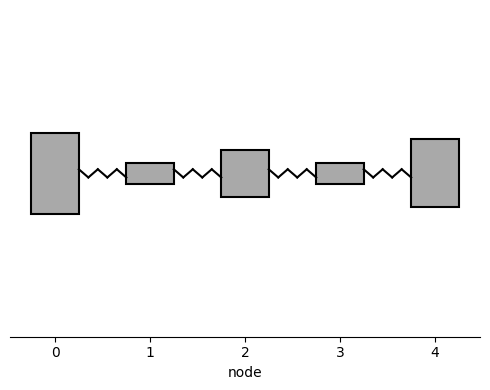

In [63]:
# To create the assembly, first the created elements are added to lists
shafts = [shaft1, shaft2, shaft3, shaft4]
disks = [disk1, disk2, disk3, disk4, disk5]

# An OpenTorsion model is created with the ot.Assembly() method. The previously defined elements are
# given as parameters. The method returns the assembly object.
compressor_train = ot.Assembly(shafts, disk_elements=disks)

# The assembly can be visualized using the plot_assembly method
plot_assembly(compressor_train)


## 1.3. Undamped natural frequencies


The first step is to calculate the natural frequencies of the system. This is achieved using the ot.modal_analysis() method. The method returns the calculated frequencies. It should be noted that the frequencies are obtained as complex conjugate pairs, and that the first mode frequency is 0, as there are no boundary conditions constraining the rotation of the system.

This model is represented by the basic Newtonian equation of motion

<br>
$$\frac{d^2}{dt^2}Mx(t)  + Kx(t) = 0$$
<br>

Here M is the system mass matrix, K is the system stiffness matrix and x is a vector containg the degrees of freedom for the system. These M and K matrices of the torsional system are assembled by the openTorsion assembly. According to basic theory of linear vibrations, we assume that the solution is

<br>
$$x(t) = Ae^{j(\omega t + \phi)}$$
<br>

Where A is the amplitude of the rotational displacement and $\omega$ is the angular frequency. The complex notation is assumed, however, the instantaneous mechanical values are the real parts of the respective complex numbers. The eigenvalues (natural frequencies) and eigenvectors (mode shapes) can be calculated from the resulting eigenvalue problem for the multiple degree-of-freedom case

<br>
$$\omega_n^2 \textbf{M}\boldsymbol{\phi} = \textbf{K}\boldsymbol{\phi}$$
<br>

openTorsion assembly object can perform the calculation of natural frequencies and eigenvectors based on the defined model. We have not defined any damping to the system, which means that the damped and undamped natural frequencies are identical.


In [64]:
"""
To calculate the natural frequencies of the system, the ot.modal_analysis() method
of the assembly is called. The method returns three lists:
  1. the undamped natural frequencies (wn) in rad/s
  2. the damped natural frequencies (wd) in rad/s
  3. the damping ratios (dr)

rad/s can be converted to Hz by dividing the frequency with 2*pi
"""

# Calulate the natural frequencies
undamped_nf, damped_nf, damping_ratios = modal_analysis(compressor_train)

# As the solutions are in complex onjugate pairs, we only print every second value.
for wn, wd, damping_ratio in zip(undamped_nf[1::2], damped_nf[1::2], damping_ratios[1::2]):
    print(f"{wd/(2*np.pi):.2f} Hz, {wn/(2*np.pi):.2f} Hz, {np.abs(damping_ratio):.2f}".rjust(3))


0.00 Hz, 0.00 Hz, 1.00
58.71 Hz, 58.71 Hz, 0.00
124.85 Hz, 124.85 Hz, 0.00
360.98 Hz, 360.98 Hz, 0.00
378.87 Hz, 378.87 Hz, 0.00


### 1.4. Mode shapes


The mode shapes of the powertrain can be visualized using the Plots class. The plots object has methods for visualizing calculation results. Similarly to conventional modal analysis, the obtained displacements are only relative to each other. Therefore, no conclusion can be made about the magnitude of the vibration, as it depends on the loading. Modal analysis does not consider loading.


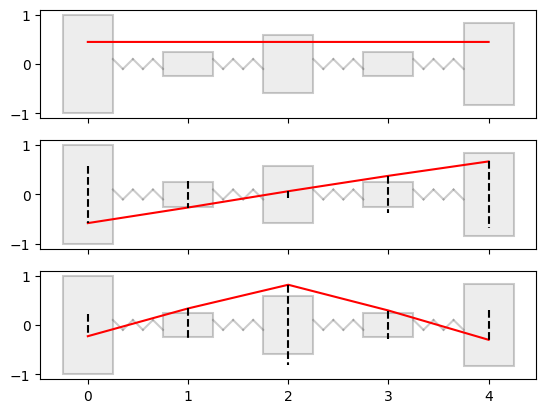

In [65]:
"""
The ot.Plots object is initialized by giving the created Assembly as a parameter.
The mode shapes can be plotted using the ot.figure_eigenmodes() method. The method
takes the number of modes to plot as a parameter. Here the three lowest modes
are plotted.
"""
plot_eigenmodes(compressor_train, modes=3)
# plot_tool.figure_eigenmodes(3)


### 1.5. Resonance interference diagram (Campbell)


A Campbell diagram is commonly used to illustrate the natural frequencies of a rotating system together with the major excitation frequencies at each rotating speed. Using the Campbell diagram, we can easily identify when the excitation frequency and detect possible resonances in the operating speed region. It is desired to have some separation margin between the operational speed and any natural frequencies. This margin is application specific and standards provide different values. Here we consider a separation margin of 10%.

The important excitation components are highly application specific. We will have a closer look at these excitation frequency components in the second part of the tutorial.


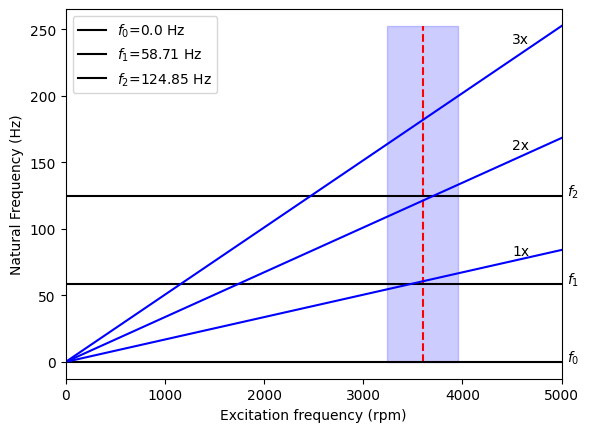

In [66]:
"""
Here we draw a Campbell diagram using the campbell_diagram method of the ot.Plots
class. The method takes as parameters the frequency range for the plot in rpm, harmonics
to be plotted and the number of natural frequencies to be included in the diagram
and the operating speed of the power train in rpm.
"""

plot_campbell(
    compressor_train, frequency_range_rpm=[0, 5000], harmonics=[1, 2, 3], num_modes=3, operating_speeds_rpm=[3600]
)


From the figure above, we see that the 1x excitation (blue line) intersects with the first natural frequency (f$_1$) of the system at almost operational speed (dotted red line). Additionally, the second natural frequency (f$_2$) is inside the separation margin (light blue area).


### <b> 1.6. EXERCISE: Coupling choice </b>


To avoid running the compressor train in a resonance condition and risk damage to the machine, modifications are suggested. The compressor, turbine and generator have already been ordered and cannot be changed. Additionally, due to lack of options from the coupling supplier, only coupling 2 can be modified. Below, we have the coupling options available at the coupling supplier.

| Coupling option | Inertia (kgm$^2$) | Stiffness (MNm/rad) |
| --------------- | ----------------- | ------------------- |
| A               | 8                 | 10                  |
| B               | 12                | 33                  |
| C               | 15                | 45                  |

Recreate the calculation model with each of the coupling options and calculate the corresponding natural frequencies. Using the Campbell diagram, choose the best coupling option to be ordered.


In [67]:
# WRITE THE ANSWER HERE


### Reveal the example solution below.


In [ ]:
"""
Based on the comparison, the best coupling choice for the system is A.
The stiffer couplings shift the first two natural frequencies up, but even with
the stiffest option, the increase is not enough to ensure the needed margin of safety.
However, with option A, the frequencies fall below the separation margin.
"""

# @title
# SOLUTION
new_coupling_inertia = 8
new_coupling_stiffness = 10e6

# Create the new disks for couling
new_coupling_1 = ot.Disk(3, I=new_coupling_inertia)

# Create new shaft elements
new_shaft1 = ot.Shaft(2, 3, L=None, odl=None, k=new_coupling_stiffness)
new_shaft2 = ot.Shaft(3, 4, L=None, odl=None, k=new_coupling_stiffness)

# Create the new lists of elements
shafts = [shaft1, shaft2, new_shaft1, new_shaft2]
disks = [disk1, disk2, disk3, new_coupling_1, disk5]

# Create new compressor_train assembly
compressor_train_example = ot.Assembly(shafts, disk_elements=disks)

# Plot the campbell diagram
plot_campbell(
    compressor_train_example,
    frequency_range_rpm=[0, 5000],
    harmonics=[1, 2, 3],
    num_modes=3,
    operating_speeds_rpm=[3600],
)


## 2. Calculating steady-state torsional vibration response

In this exercise, we calculate the torsional vibration response of an internal combustion engine. The system under consideration is a 3-cylinder four-stroke engine.

Most torsional systems can be represented by the basic Newtonian equation of motion

<br>
$$M\frac{d^2}{dt^2}{x} + C\frac{d}{dt}{x} + Kx = T.$$
<br>

In this example calculation, only the inertia and stiffness values are provided, and the damping matrix C is included as 2% modal damping in all modes, this is done directly with openTorsion software. When steady-state responses are calculated, it is assumed that the system is linear, i.e., the sinusoidal input force at any frequency results in a displacement with equal frequency but different phase and amplitude. The complex notation is assumed, however, the actual mechanical torque and displacement are the real part of the respective complex values.

When the sinusoidal force and response model is assumed as

<br>
$$x(t) = Ae^{j(\omega t + \phi)}, \quad T(t) = Be^{j(\omega t + \theta)}.$$
<br>

Substitution to the equation of motion and evaluating the derivatives yields

<br>$$
-M\omega^2Ae^{j(\omega t + \phi)} + Cj\omega Ae^{j(\omega t + \phi)} + KAe^{j(\omega t + \phi)} = Be^{j(\omega t + \theta)}.

$$
<br>

As all the time dependent terms cancel out from this equation (remember $a^{b+c} = a^ba^c$),

<br>
$$

-M\omega^2Ae^{j\phi} + Cj\omega Ae^{j\phi} + KAe^{j\phi} = Be^{j\theta}.

$$
<br>

The steady-state displacement response (magnitude $A$ and phase $\phi$ ) can be calculated for the known input torque (frequency $2\pi\omega$, magnitude $B$ and phase $\theta$) as

<br>
$$

Ae^{j\phi} = (-M\omega^2 + Cj\omega + K)^{-1}Be^{j\theta},

$$
<br>

or

$$x = (-M\omega^2 + Cj\omega + K)^{-1}T.$$
<br>

Note that in this last equation the torsional angle x and input torque T are complex numbers and no longer time-dependent, hence this is called a steady-state solution.
$$


###<b> 2.1. EXERCISE: Create model</b>

The modeling process starts by defining the lumped element model. The model consists of 5 lumped inertias, and 4 connecting shafts. Create the model with the following elements and calculate the undamped natural frequencies and plot the Campbell diagram.


Disk elements:

| Component  | Inertia (kgm$^2$) |
| ---------- | ----------------- |
| Cylinder 1 | 0.0035            |
| Cylinder 2 | 0.0035            |
| Cylinder 3 | 0.0035            |
| Flywheel   | 0.15              |
| Generator  | 0.05              |

Shaft elements:

| Component                                  | Torsional stiffness (Nm/rad) |
| ------------------------------------------ | ---------------------------- |
| Crankshaft between cylinder 1 and 2        | 12000                        |
| Crankshaft between cylinder 2 and 3        | 12000                        |
| Crankshaft between cylinder 3 and flywheel | 14000                        |
| Coupling between flywheel and generator    | 10000                        |

Correct undamped natural frequencies in Hz are:
0.00,
81.21,
141.21,
378.95,
536.36


In [69]:
# WRITE THE ANSWER HERE

# save the assembly to a variable named compressor_train for the later parts


Reveal the example solution below.


In [ ]:
# @title
# Lumped inertias
disk1 = ot.Disk(0, I=3.5e-3)
disk2 = ot.Disk(1, I=3.5e-3)
disk3 = ot.Disk(2, I=3.5e-3)
disk4 = ot.Disk(3, I=0.15)
disk5 = ot.Disk(4, I=0.05)

# Connecting shaft elements
shaft1 = ot.Shaft(0, 1, L=None, odl=None, k=12e3)
shaft2 = ot.Shaft(1, 2, L=None, odl=None, k=12e3)
shaft3 = ot.Shaft(2, 3, L=None, odl=None, k=14e3)
shaft4 = ot.Shaft(3, 4, L=None, odl=None, k=10e3)

# Create the assembly with the defined elments
disks = [disk1, disk2, disk3, disk4, disk5]
shafts = [shaft1, shaft2, shaft3, shaft4]
crankshaft = ot.Assembly(shafts, disk_elements=disks)

# The assembly can be visualized using the plot_assembly method
plot_assembly(compressor_train)

# Calculate the undamped natural frequencies
natural_frequencies, _, _ = modal_analysis(crankshaft)
print("Natural frequencies:")
for n in natural_frequencies[::2]:
    print(f"{n/(2*np.pi):.2f} Hz")  # Calculated natural angular frequencies are in rad/s


### 2.2. Define excitations

The firing sequence is 1-2-3. The excitation model for each cylinder is typically defined by the OEM. Fourier components at 0.5, 1, 1.5, 2 .., of the running speed are used for four-stroke engines. The phase and magnitude for each harmonic is provided, along with the constant DC component.

Looking at the vector form of the previously derived steady-state equation

<br>
$$x = (-M\omega^2 + Cj\omega A + K)^{-1}T$$
<br>

or the 5 degree of freedom system at hand

<br>
$$\begin{bmatrix}x_1\\x_2\\x_3\\x_4\\x_5 \end{bmatrix} = (-M\omega^2 + Cj\omega A + K)^{-1} \begin{bmatrix} T_1 \\T_2 \\T_3 \\T_4 \\T_5 \end{bmatrix}$$
<br>

So the input torque vector has 5 components, each corresponding to the respective lumped inertia in the model.


In [71]:
# DC component (Nm)
DC_torque = 70.8

# Fourier components of the exciation at each cylinder
# Mag (Nm), phase (rad), harmonic (-)
excitation_data = np.array(
    [
        [174.1, -2.0573, 0.5],
        [180.8, 2.2305, 1],
        [173.5, 0.3922, 1.5],
        [128.2, -1.2805, 2],
        [134.5, -3.1321, 2.5],
        [99.7, 1.4381, 3],
        [96.2, -0.2701, 3.5],
        [79.3, -1.972, 4],
        [68.1, 2.5815, 4.5],
        [57, 0.8868, 5],
    ]
)

# Collect the values to variables
magnitudes = excitation_data[:, 0]  # First column is magnitudes
thetas = excitation_data[:, 1]  # Second column is the phases
harmonics = excitation_data[:, 2]  # Third column is the harmonics
complex_excitations = magnitudes * np.exp(1.0j * thetas)  # in complex number format

"""
The excitations act on each cylinder node of the crankshaft
A matrix is assembled where each row represents one cylinder, and each
Column represents one excitation frequency
A 4/3*pi (240 degree) phase difference is added between each cylinder
"""

phase_shift = 4 / 3 * np.pi
crankshaft_excitation = np.zeros([5, excitation_data.shape[0]], dtype="complex128")
crankshaft_excitation[0] = complex_excitations
crankshaft_excitation[1] = complex_excitations * np.exp(-1.0j * harmonics * phase_shift)
crankshaft_excitation[2] = complex_excitations * np.exp(1.0j * harmonics * phase_shift)

print("Dimensions of the excitation array, should be (number of nodes x number of excitation components)")
print(crankshaft_excitation.shape)


Dimensions of the excitation array, should be (number of nodes x number of excitation components)
(5, 10)


### 2.3. Plot the defined excitation

It is always recommended to verify that the excitations have been correctly implemented by plotting them in the time-domain. In this section we focus on one rotating speed, where there are in total 10 harmonic components in the cylinder torque.

When the amplitude, phase and frequency of the torque is known, the timeseries can be plotted by taking the real value of the complex torque

<br>
$$T(t) = \Re(Be^{j(\omega t + \theta)}) = \Re(Be^{j\theta}e^{j\omega t}) $$
<br>

The total cylinder torque is the sum of all 10 torque harmonics and the DC component, as described in previous section.

Here we can also verify that the firing sequence is correctly implemented by plotting all of the 3 cylinder torques in the same figure.


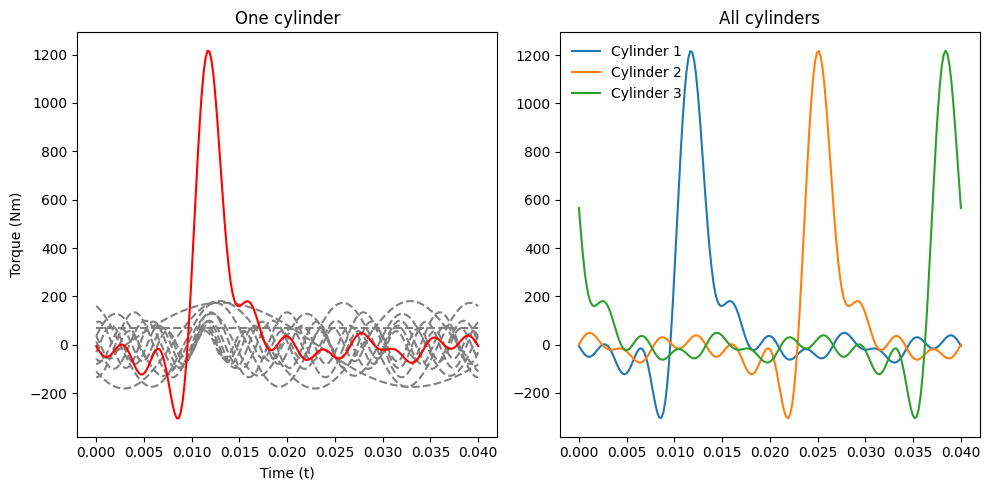

In [72]:
w = 3000 * (2 * np.pi) / 60  # Base angular frequency, only one rotating speed is considered in this part
t = np.linspace(0, 2 * 2 * np.pi / w, 200)  # Two revolutions of the crankshaft, 200 points

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Initiate a zero vector for the sum excitation time series
sum_wave = np.zeros_like(t)

# Loop over each harmonic component of the excitation
for excitation, harmonic in zip(complex_excitations, harmonics):
    omega = harmonic * w  # Calculate the excitation frequency based on the base frequency
    this_wave = np.real(excitation * np.exp(1.0j * (omega * t)))  # Get the real part of the complex torque

    # Cumulate the result for the sum excitation
    sum_wave += this_wave

    # Plot the individual component on background
    ax1.plot(t, this_wave, "--", c="gray")

# Add the DC component to background and to the signal
ax1.plot(t, np.ones_like(t) * DC_torque, "--", c="gray")
sum_wave += DC_torque

# Plot the sum excitation signal
ax1.plot(t, sum_wave, c="red")

# Same as above, but loop over the 3 excitations
for i in range(3):
    sum_wave = np.zeros_like(t)
    excitations_shifted = crankshaft_excitation[i]
    # Calculate the sum signal as above
    for excitation, harmonic in zip(excitations_shifted, harmonics):
        omega = w * harmonic
        this_wave = np.real(excitation * np.exp(1.0j * (omega * t)))
        sum_wave += this_wave
    ax2.plot(t, sum_wave + DC_torque, label=f"Cylinder {i+1}")

ax1.set_xlabel("Time (t)")
ax1.set_ylabel("Torque (Nm)")
ax1.set_title("One cylinder")
ax2.set_title("All cylinders")
ax2.legend()
legend = plt.gca().get_legend()
legend.set_frame_on(False)
plt.tight_layout()
plt.show()


### 2.4. Calculate vibratory torque at one rotating speed

The process of calculating responses starts from solving the steady-state angular displacements for each of the lumped inertias.
The system consists of four shafts, each of them is carrying torque, which is calculated by solving the system as described in section 2.2. The response in twist angle is transferred to shaft torque $T_v$ by subtracting the consecutive responses and multiplying by the respective torsional stiffness.

<br>
$$
T_v[i] = k[i](x[i+1]-x[i])
$$
<br>

The static DC-component of the torque is omitted in this calculation


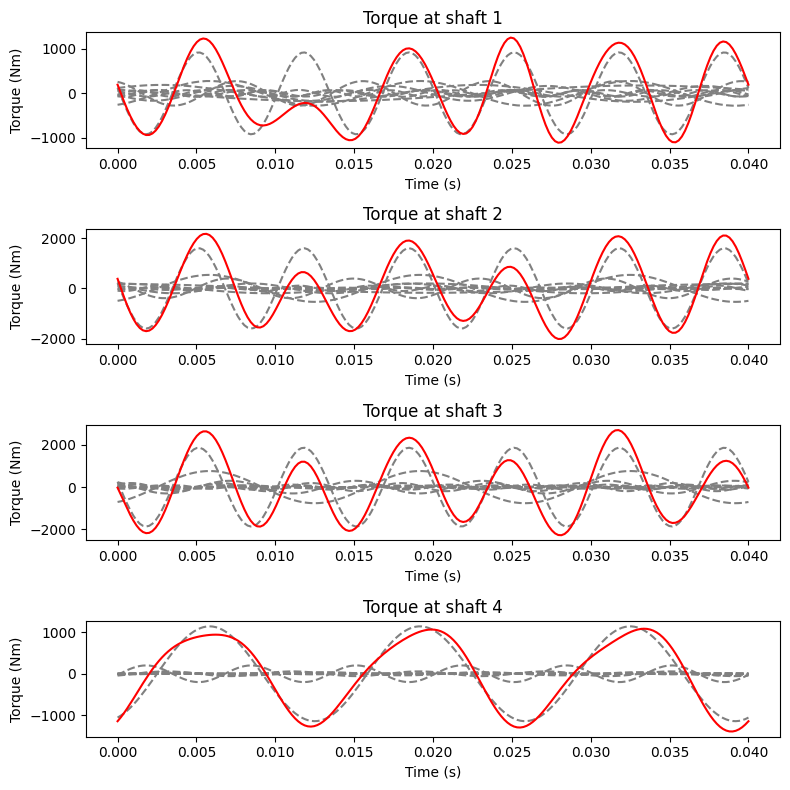

In [73]:
# Define the finite-element matrices, use 2% modal damping for all modes
M, C, K = crankshaft.M(), crankshaft.C(), crankshaft.K()
C = crankshaft.C_modal(M, K, xi=0.05)
C = np.zeros_like(C)
w = 3000 * (2 * np.pi) / 60  # Base angular frequency (3000 RPM)
t = np.linspace(0, 2 * 2 * np.pi / w, 200)  # Two revolutions of the crankshaft, used for plotting

# Create array with the excitation angular frequencies at this rotating speed
omegas = w * harmonics

# The excitation amplitudes and phases are already in the crankshaft_excitation variable
q_res, w_res = ss_response(crankshaft_excitation, omegas, M, C, K)

# Calculate the angle difference between two consecutive nodes
q_difference = (q_res.T[:, 1:] - q_res.T[:, :-1]).T

# initiate 4 subplots for the 4 shafts
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

# Shaft stiffness values are used to calculate the torque from the angle differences
shaft_stiffness = [12e3, 12e3, 14e3, 10e3]

# Loop over the 4 shafts to plot the response for each of them
for n in range(4):
    shaft_response = q_difference[n]
    sum_wave = np.zeros_like(t)
    # Loop over the harmonic components and cumulate the result
    for i, (response_component, harmonic) in enumerate(zip(shaft_response, harmonics)):
        # Get the waveform of each response component
        this_wave = np.real(response_component * np.exp(1.0j * harmonic * w * t))

        # Cumulate the sum wave
        sum_wave += this_wave

        # Plot the individual component in newton meters
        axes[n].plot(t, this_wave * shaft_stiffness[n], "--", c="gray")

    # Plot the sum excitation signal in newton meters
    axes[n].plot(t, sum_wave * shaft_stiffness[n], c="red")

    axes[n].set_title(f"Torque at shaft {n+1}")
    axes[n].set_xlabel("Time (s)")
    axes[n].set_ylabel("Torque (Nm)")
plt.tight_layout()
plt.show()


### 2.5. Calculate total response at all operating speeds

In the above, we have calculated the torsional response at one rotating speed. Machines are rarely run at only one operating speed. For this reason, the absolute values of the individual harmonic response components can be summed up to give an approximation of the maximum vibration amplitude at a given operating speed. This maximum vibratory torque value is then plotted against the rotating speed of the machine.


In [74]:
operating_speeds_rads = np.linspace(5, 500, 500)
operating_speeds_rpm = operating_speeds_rads / (2 * np.pi) * 60
M, K = crankshaft.M(), crankshaft.K()
C = crankshaft.C_modal(M, K, xi=0.02)
q_response = []

# Loop over all rotating speeds
for w in operating_speeds_rads:
    omegas = harmonics * w
    q_res, _ = ss_response(crankshaft_excitation, omegas, M, C, K)
    q_difference = (q_res.T[:, 1:] - q_res.T[:, :-1]).T
    q_response.append(q_difference)

q_response = np.array(q_response)

# Total response
sum_response = np.sum(np.abs(q_response), axis=2)

q_response = np.abs(q_response)


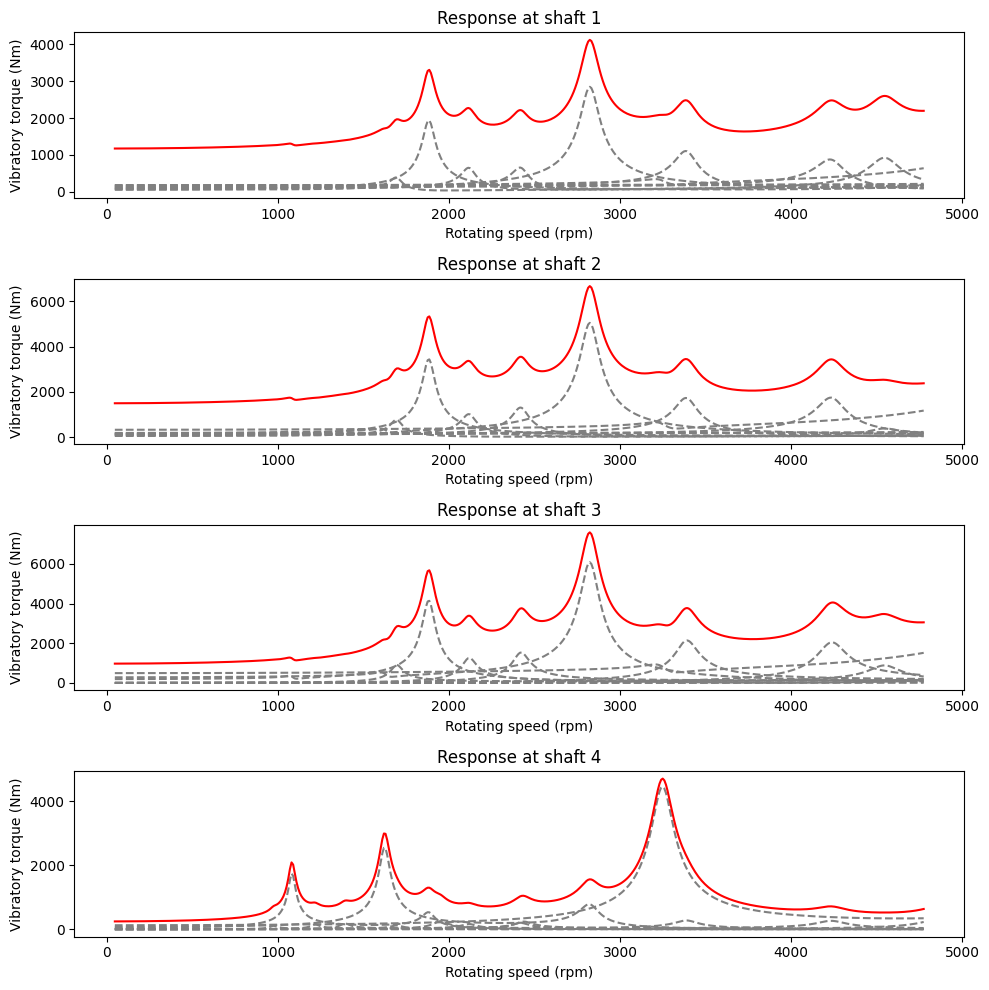

In [75]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))
shaft_stiffness = [12e3, 12e3, 14e3, 10e3]

for i in range(4):
    for k in range(len(complex_excitations)):
        axes[i].plot(operating_speeds_rpm, q_response[:, i, k] * shaft_stiffness[i], "--", c="gray")

for i in range(4):
    axes[i].plot(operating_speeds_rpm, sum_response[:, i] * shaft_stiffness[i], c="red")
    axes[i].set_title(f"Response at shaft {i+1}")
    axes[i].set_xlabel("Rotating speed (rpm)")
    axes[i].set_ylabel("Vibratory torque (Nm)")

plt.tight_layout()
plt.show()
